In [1]:
from __future__ import print_function
from __future__ import division

import sys
import torch
import torch.utils.data as data
import os
import time
import pickle
import numpy as np
from PIL import Image
import re
import io

import json
import matplotlib.pyplot as plt
from torchvision import transforms, datasets, models
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.nn.functional as F



from IPython.display import clear_output
import torch.nn as nn
import torch.optim as optim

import itertools
import collections
import pdb
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
cuda

False

In [2]:
# Path for file dset_dataloader.json
def open_json(path):
    f = open(path) 
    data = json.load(f) 
    f.close()
    return data 

def flatten(S):
    if S == []:
        return S
    if isinstance(S[0], list):
        return flatten(S[0]) + flatten(S[1:])
    return S[:1] + flatten(S[1:])

### Bar to visualize progress

In [3]:
def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))
    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

In [84]:
# IMAGES
im_path_fur = '/Users/manuelladron/iCloud_archive/Documents/_CMU/PHD-CD/PHD-CD_Research/ADARI/images/ADARI_v2/furniture/full'


# WORD EMBEDDINGS
word_embeddings_path = "/Users/manuelladron/iCloud_archive/Documents/_CMU/PHD-CD/PHD-CD_Research/ADARI/json_files/embeddings/adari/fur_5c_50d_sk_glove_ft.json"
word_embeddings_path_2 = "/Users/manuelladron/iCloud_archive/Documents/_CMU/PHD-CD/PHD-CD_Research/ADARI/json_files/embeddings/adari/v2/fur_v2_5c_50d_adjs.json"


# IMAGE EMBEDDINGS
img_embds_id_p = "/Users/manuelladron/iCloud_archive/Documents/_CMU/PHD-CD/PHD-CD_Research/ADARI/json_files/image_embeddings/furniture/afur_resnet_emb_id.json"
img_embds_name_p = "/Users/manuelladron/iCloud_archive/Documents/_CMU/PHD-CD/PHD-CD_Research/ADARI/json_files/image_embeddings/furniture/afur_resnet_emb_names.json"

# FILES FOR DATALOADER
dset_words_p = "/Users/manuelladron/iCloud_archive/Documents/_CMU/PHD-CD/PHD-CD_Research/ADARI/json_files/cleaned/ADARI_v2/furniture/ADARI_furniture_words.json"
vocab_p = "/Users/manuelladron/iCloud_archive/Documents/_CMU/PHD-CD/PHD-CD_Research/ADARI/json_files/cleaned/ADARI_v2/furniture/ADARI_furniture_vocab_adjs.json"

In [85]:
# Open json files with embeddings 
image_embeddings = open_json(img_embds_name_p)
dataset_labels = open_json(dset_words_p)
labels_embeddings = open_json(word_embeddings_path)
labels_embeddings_v2 = open_json(word_embeddings_path_2)
vocab = open_json(vocab_p)

### Transform dictionary of ordered labels to list of labels 

In [86]:
glove_path = '/Users/manuelladron/iCloud_archive/Documents/_CMU/PHD-CD/PHD-CD_Research/ADARI/json_files/embeddings/glove/glove.6B.50d.txt'
with io.open(glove_path, 'r', encoding='utf8') as f:    
    glove_file = f.read()
    
glove_sentences = glove_file.splitlines()
glove_vocab = {}
for sentence in glove_sentences:
    word = sentence.split()[0]
    embedding = np.array(sentence.split()[1:], dtype = float)
    glove_vocab[word] = embedding

### nasty temporal vector for unknowns (not using it glove nor avg vector)

In [ ]:
vocab_embeddings = dict()
c = 0
f = 0
for word in vocab.keys():
    try:
        emb = labels_embeddings[word]
        c += 1
    except:
        try:
            emb = labels_embeddings_v2[word]
            c += 1
        except:
            try:
                emb = glove_vocab[word]
            except:
                emb = AVG_VECTOR
                f+=1
    
    vocab_embeddings[word] = emb
    

In [88]:
c, f, len(vocab_embeddings)

(7491, 0, 7491)

In [10]:
with open(glove_path, 'r') as f:
    for i, line in enumerate(f):
        pass
n_vec = i + 1
hidden_dim = len(line.split(' ')) - 1

vecs = np.zeros((n_vec, hidden_dim), dtype=np.float32)

with open(glove_path, 'r') as f:
    for i, line in enumerate(f):
        vecs[i] = np.array([float(n) for n in line.split(' ')[1:]], dtype=np.float32)

#AVG_VECTOR = np.mean(vecs, axis=0) # NOT USING 

In [11]:
def sampling_rate_and_negative_sample(vocab, w2i):
    # Returns sampling rate of word (prob of keeping the word ) and negative sampling rate
    # 1) variables for sampling_rate
    
    frequencies_ids = dict()
    frequencies = dict()
    total_number_words = sum(vocab.values())
    threshold = 1e-5
    for word, count in vocab.items():
        # for sampling rate 
        z_w = count / total_number_words # this all add up to 1
        frequencies[word] = z_w
        w_id = w2i[word]
        frequencies_ids[w_id] = z_w

    # Noise_dist
    noise_dist = {key:val**(3/4) for key, val in frequencies.items()}
    
    # Frequency of dropping
    p_drop = {word: 1 - np.sqrt(threshold/frequencies[word]) for word in vocab}
    
    # Noise dist normalized 
    Z = sum(noise_dist.values())
    neg_sampling = dict()
    neg_sampling_ids = dict()
    
    for k, v in noise_dist.items():
        k_id = w2i[k]
        n_s_value = v/Z
        neg_sampling[k] = n_s_value
        neg_sampling_ids[k_id] = n_s_value

    return frequencies, frequencies_ids, neg_sampling, neg_sampling_ids, p_drop

In [12]:
def im2idx_w2idx(im_words, vocab):
    # The 2 dictionaries below for dataset dataloader
    im2idx = dict()
    idx2im = dict()
    w2i = dict()
    i2w = dict()
    for i,image_name in enumerate(im_words.keys()):
        im2idx[image_name] = i
        idx2im[i] = image_name

    for i, w in enumerate(vocab.keys()):
        w2i[w] = i
        i2w[i] = 2
    
    return im2idx, idx2im, w2i, i2w

In [13]:
im2id, id2im, w2i, i2w = im2idx_w2idx(dataset_labels, vocab)
s_rate, s_rate_ids, n_rate, n_rate_ids, p_drop = sampling_rate_and_negative_sample(vocab, w2i)

### Split dataset into train, validation and test

In [14]:
import random

def shuffle_dict(d):
    l = list(d.items())
    random.shuffle(l)
    d = dict(l)
    return d

def splitDict(d_img_words, percent, val_number):

    val_n = val_number
    train_test_size = len(d_img_words) - val_n
    train_n = int(train_test_size*percent)
    test_n = train_test_size - train_n
    
    d_img_words = shuffle_dict(d_img_words)
    
    im_words = iter(d_img_words.items())      
    
    # Image - words
    dtrain_imw = dict(itertools.islice(im_words, train_n))  
    dtest_imw = dict(itertools.islice(im_words, test_n))   
    dval_imw = dict(itertools.islice(im_words, val_n))
    
    
    print('trainset size: ', len(dtrain_imw), 'dataset size: ',len(dtest_imw), 'val set size: ', len(dval_imw))
    return dtrain_imw, dtest_imw, dval_imw 

In [15]:
dtrain_w, dtest_w, dval_w = splitDict(dataset_labels, .95, 500)

trainset size:  16180 dataset size:  852 val set size:  500


In [16]:
img_size = 64
class ADARIdataset(Dataset):
    """
    Receives images and labels.
    Returns tensor image and tensor labels
    """
    def __init__(self, labels_data, word_embeddings, image_embeddings, w2i, i2w, im2id, id2im,
                 s_rate, n_rate, p_drop, img_path):

        self.labels_data = labels_data   # dictionary of images -> labels
        self.word_embeds = word_embeddings
        
        self.images_names = list(self.labels_data.keys())    # names
        self.images_embeds = list(image_embeddings.values()) # values
        
        self.w2i = w2i
        self.i2w = i2w
        self.im2id = im2id
        self.id2im = id2im
        
        self.sampling_r = s_rate
        self.neg_sampling = n_rate
        self.pdrop = p_drop
        
        self.image_path = img_path
        self.number_adjs = 5
        
    def __len__(self):
        return len(self.images_names)
    
    def get_image_tensor(self, image_name):
        """
        Gets image name and returns a tensor
        """
        name = self.image_path + "/" + image_name
        img = Image.open(name)
        img = transforms.Compose([
        transforms.Resize(64),
        transforms.CenterCrop(64),
        transforms.ToTensor()])(img)
        
        return img
        
    def get_labels_embeddings_from_idx(self, idx):

        name_image = self.images_names[idx]
        labels = self.labels_data[name_image]
        # Set random distribution for setting a max number of labels
        
        labels1 = np.random.choice(labels, self.number_adjs)
        labels2 = np.random.choice(labels, self.number_adjs)
        
        # Get positive and negative labels
        all_idx = list(self.w2i.values())
        pos_idxs = []
        
        # Remove indexes that correspond to the positive labels
        for l in labels:
            v2i = self.w2i[l]
            pos_idxs.append(v2i)
            
            if v2i in all_idx:
                all_idx.remove(v2i)
        
        # Choose random labels as negative samples -> this can be improved with info about distance of labels
        #neg_s_norm = [s/sum(all_idx) for s in all_idx]
        
        neg_idxs = np.random.choice(all_idx, self.number_adjs)#, p=neg_s_norm)
        
        neg_samples = []
        for n in neg_idxs:
            neg_samples.append(self.i2w[n])
        
        assert(len(labels1) == len(neg_samples))
        
        pos1_w_embs = []
        pos2_w_embs = []
        neg_w_embs = []
        
        # positive1
        for l in labels1:
            try:
                pos1_w_embs.append(self.word_embeds[l.lower()]) # appending 50 vector embedding
            except:
                try:
                    pos1_w_embs.append(glove_vocab[l.lower()])
                except:
                    pos1_w_embs.append(AVG_VECTOR)
        
        # positive2
        for l in labels2:
            try:
                pos2_w_embs.append(self.word_embeds[l.lower()]) # appending 50 vector embedding
            except:
                try:
                    pos2_w_embs.append(glove_vocab[l.lower()])
                except:
                    pos2_w_embs.append(AVG_VECTOR)
    
    
        # negative
        for nl in neg_samples:
            try:
                neg_w_embs.append(self.word_embeds[nl.lower()]) # appending 50 vector embedding
            except:
                try:
                    neg_w_embs.append(glove_vocab[nl.lower()])
                except:
                    neg_w_embs.append(AVG_VECTOR)
                               
        return pos1_w_embs, pos2_w_embs, neg_w_embs
    
    def __getitem__(self, index):
        """
        Return tensor image and label embedding
        """
        name_image = self.images_names[index]
        img = self.get_image_tensor(name_image)

        pos1_label_embs, pos2_label_embs, neg_label_embs = self.get_labels_embeddings_from_idx(index) # list size variable 
        
        return img, pos1_label_embs, pos2_label_embs, neg_label_embs, name_image
 

def collate(sequence):
    """
    "the input of this function is the output of function __getitem__"
    "this gets BATCH_SIZE times GETITEM! "
    if batch_Size == 2 --> sequence is a list with length 2. 
    Each list is a tuple (image_embedding, labels_embedding) = (2048 vector, list of vectors size 50)
    Pad labels with maximum from batch
    """
    # Concatenate all images in the batch
    # For images (not embeddigns)
    images = torch.cat(([torch.FloatTensor(batch[0]).view(-1, 3, 64, 64) for batch in sequence]), dim=0)
    pos1_labels = torch.cat(([torch.FloatTensor(batch[1]).view(-1, 5, 50) for batch in sequence]), dim=0)
    pos2_labels = torch.cat(([torch.FloatTensor(batch[2]).view(-1, 5, 50) for batch in sequence]), dim=0)
    neg_labels = torch.cat(([torch.FloatTensor(batch[3]).view(-1, 5, 50) for batch in sequence]), dim=0)
    
    names = [batch[4] for batch in sequence]
    return images, pos1_labels, pos2_labels, neg_labels, names
    #return images, pos_labels, neg_labels, labels_length, names

In [17]:
dataset_train = ADARIdataset(dtrain_w, labels_embeddings, image_embeddings, w2i, i2w, im2id, id2im,
                 s_rate, n_rate, p_drop, im_path_fur)
dataset_test = ADARIdataset(dtest_w, labels_embeddings, image_embeddings, w2i, i2w, im2id, id2im,
                 s_rate, n_rate, p_drop, im_path_fur)
dataset_val = ADARIdataset(dval_w, labels_embeddings, image_embeddings, w2i, i2w, im2id, id2im,
                 s_rate, n_rate, p_drop, im_path_fur)


In [18]:
batch_size = 64
num_workers = 8 if cuda else 0

In [19]:
train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, collate_fn = collate, num_workers=num_workers, drop_last=False)
test_dataloader = DataLoader(dataset_test, batch_size=batch_size, shuffle=False,collate_fn = collate, num_workers=num_workers, drop_last=False)
val_dataloader = DataLoader(dataset_val, batch_size=1, shuffle=False,collate_fn = collate, num_workers=num_workers, drop_last=False)

In [20]:
# to test dataloader
it = iter(test_dataloader)

min_ = 10000
for i in range(len(test_dataloader)-100):
    first = next(it)
    if first[1].shape[1] < min_:
        min_ = first[1].shape[1]
print(min_)
   # print(second[0].shape, second[1].shape, second[2])

10000


### Image embedding

In [21]:
feature_extract = False
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [22]:
def initialize_model(num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    model_ft = models.resnet152(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, num_classes)
    input_size = 64
    
    return model_ft, input_size

model_ft, input_size = initialize_model(50, feature_extract)
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [23]:
model_ft.fc.weight.shape

torch.Size([50, 2048])

### Matching CNN 

In [24]:
# MULTICONVOLUTION CONCATENATING
class matchingCNN(nn.Module):
    """
   
    """
    def __init__(self):
        super(matchingCNN, self).__init__()
        
        # Multimodal Convolution 
        self.cnn1 = nn.Conv1d(in_channels = 1, out_channels = 200,  kernel_size = 12, padding=0, stride=2)
        self.max1 = nn.MaxPool1d(2, stride=2)
        
        # 2nd Convolution
        self.cnn2 = nn.Conv1d(in_channels = 200, out_channels = 300, kernel_size = 12, padding=0, stride=2)
        self.max2 = nn.MaxPool1d(2, stride=2)
        
        # 3rd Convolution
        self.cnn3 = nn.Conv1d(in_channels = 300, out_channels = 300, kernel_size = 12, padding=0, stride=2)
        self.max3 = nn.MaxPool1d(2, stride=2)
                    
    def forward(self, image_feature, labels, labels_lengths):
        batch_size = labels.shape[0]
        max_length_per_batch = labels.shape[1]
        dim_labels = labels.shape[2]
        dim_image = image_feature.shape[1]
        
        # Mixing image and labels 
        new_vectors = [] # [batch, max_length, dim*3+256]
        receptive_field_words = 3
        new_vector_length = receptive_field_words * (dim_labels + dim_image)
        
        for i in range(labels.shape[1]): # iterating over words 
            next3words = labels[:, i:i+3, :] 
            next3words = next3words.view(batch_size, -1)
            words_img = torch.cat((next3words, image_feature), 1).unsqueeze(1) # [batch, 1, 200]
            len_last_dim = words_img.shape[2]
            
            if len_last_dim != new_vector_length:
                pad_times = new_vector_length - len_last_dim
                words_img = F.pad(words_img, (0, pad_times), "constant", 0)
            new_vectors.append(words_img)
        
        joint = torch.cat((new_vectors),1) # [batch, 20, 406]

        # Reshaping matrix
        joint = joint.view(-1, 1, new_vector_length) # [batch*20, 1, 406]
#         print('joint matrix shape: ', joint.shape)
        joint = F.relu(F.dropout(self.cnn1(joint), .1))
#         print('after first convolution: ', joint.shape)
        joint = self.max1(joint)
#         print('after maxpool1: ', joint.shape)

        joint = F.relu(F.dropout(self.cnn2(joint), .1))
#         print('after conv2: ', joint.shape)
        joint = self.max2(joint)
#         print('after 2nd maxpool: ', joint.shape)
        joint = F.relu(F.dropout(self.cnn3(joint), .1))
#         print('after conv3: ', joint.shape)
        joint = self.max3(joint)
#         print('after 3rd maxpool: ', joint.shape)
        
        joint = joint.view(batch_size, -1)
#         print(joint.shape)
        return joint
        
    
    

In [25]:
class Scoring_function(nn.Module):
    def __init__(self):
        super(Scoring_function, self).__init__()
        self.fc1 = nn.Linear(1500, 400)
        self.fc2 = nn.Linear(400, 1)
        
    def forward(self, x): 
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [26]:
def margin_ranking_loss(margin, score_good, score_bad):
    cost = (margin - score_good + score_bad)
    z = torch.zeros_like(cost)
    loss = torch.max(z, cost)
    return loss

In [27]:
def normalize_vec(vec):
    norm = vec.norm(p=2, dim=1, keepdim=True)
    vec_norm = vec.div(norm)
    return vec_norm

In [28]:
tar = torch.ones(3)*-1
tar

tensor([-1., -1., -1.])

In [29]:
def train_epoch(img_cnn, matching_cnn, mlp, train_loader, optimizer, criterion):
    img_cnn.train()
    matching_cnn.train()
    mlp.train()
    
    running_loss = 0.0
    total_predictions = 0.0
    correct_predictions = 0.0
    
    
    predictions = []
    ground_truth = []
    
    start_time = time.time()
    for batch_idx, (data, pos1_labels, pos2_labels, neg_labels, names) in enumerate(train_loader):   
        optimizer.zero_grad()   # .backward() accumulates gradients
        data = data.to(device)
        
        pos1_labels = pos1_labels.to(device) # [batch, 50, max_length]
        pos2_labels = pos2_labels.to(device) # [batch, 50, max_length]
        neg_labels = neg_labels.to(device) # [batch, 50, max_length]
        
        # image_CNN
        im_repres = img_cnn(data)     # [batch, 50]
        im_repres = F.relu(im_repres) # [batch, 50]
        
        # Matching CNN - VJR in the paper 
        joint_repre_related1 = matching_cnn(im_repres, pos1_labels, length)   # [batch, 3000]
        joint_repre_related2 = matching_cnn(im_repres, pos2_labels, length)   # [batch, 3000]
        joint_repre_unrelated = matching_cnn(im_repres, neg_labels, length) # [batch, 3000]
        
        
        # Scoring mLP
        score_good1 = mlp(joint_repre_related1)   # [batch, 1] -> float
        score_good2 = mlp(joint_repre_related2)   # [batch, 1] -> float
        score_bad = mlp(joint_repre_unrelated)  # [batch, 1] -> float
        
#         ys = torch.ones_like(score_good)
        # margin loss 
        #loss = criterion(score_good, score_bad, ys)
        # triple loss 
        loss = criterion(score_good1, score_good2, score_bad)
    
#         loss = margin_ranking_loss(0.5, score_good, score_bad)
        
        if batch_idx % 10 == 0 and batch_idx != 0:
#             print('sg: ', score_good.item())
#             print('sb: ', score_bad.item())
            print('loss: ', loss.item())
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    end_time = time.time()
    
    loss_epoch = running_loss / len(train_loader)
    print('------ Training -----')
    return loss_epoch

In [30]:
def test_epoch(img_cnn, matching_cnn, mlp, test_loader, criterion):
    img_cnn.eval()
    matching_cnn.eval()
    mlp.eval()
    
    running_loss = 0.0
    total_predictions = 0.0
    correct_predictions = 0.0
    
    predictions = []
    ground_truth = []

    with torch.no_grad():
        for batch_idx, (data, pos1_labels, pos2_labels, neg_labels, names) in enumerate(test_loader):   
            data = data.to(device)
            pos1_labels = pos1_labels.to(device) # [batch, 50, max_length]
            pos2_labels = pos2_labels.to(device) # [batch, 50, max_length]
            neg_labels = neg_labels.to(device) 

            # image_CNN
            im_repres = img_cnn(data) # [batch, 50]
            im_repres = F.relu(im_repres)

            # Matching CNN
            joint_repre_related1 = matching_cnn(im_repres, pos1_labels, length)
            joint_repre_related2 = matching_cnn(im_repres, pos2_labels, length)   # [batch, 3000]
            joint_repre_unrelated = matching_cnn(im_repres, neg_labels, length)

            # Scoring mLP
            score_good1 = mlp(joint_repre_related1)   # [batch, 1] -> float
            score_good2 = mlp(joint_repre_related2)   # [batch, 1] -> float
            score_bad = mlp(joint_repre_unrelated)
            
#             ys = torch.ones_like(score_good)
#             loss = criterion(score_good, score_bad, ys)
            
            # triple loss 
            loss = criterion(score_good1, score_good2, score_bad)
            
            
            #loss = margin_ranking_loss(0.5, score_good, score_bad)
            if batch_idx % 10 == 0 and batch_idx != 0:
#                 print('sg: ', score_good.item())
#                 print('sb: ', score_bad.item())

                print('loss: ', loss.item())

            running_loss += loss.item()
    
    
    loss_epoch = running_loss / len(test_loader)
    print('------ Testing -----')
    return loss_epoch

In [31]:
# MODELS 
device = torch.device("cuda" if cuda else "cpu")
image_CNN = model_ft.to(device)
matching_CNN = matchingCNN().to(device)
scoring_MLP = Scoring_function().to(device)
# criterion = nn.MarginRankingLoss(margin=0.5)
criterion = nn.TripletMarginLoss(margin=0.5)
# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.

params_to_update = model_ft.parameters()
# print("Params to learn:")
# if feature_extract:
#     params_to_update = []
#     for name, param in model_ft.named_parameters():
#         if param.requires_grad == True:
#             params_to_update.append(param)
#             print("\t",name)
# else:
#     for name,param in model_ft.named_parameters():
#         if param.requires_grad == True:
#             print("\t",name)

params = list(params_to_update) + list(matching_CNN.parameters()) + list(scoring_MLP.parameters())

# optimizer = optim.Adam(model.parameters(), lr = 0.001)
#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Observe that all parameters are being optimized
optimizer = optim.SGD(params, lr=0.001, momentum=0.9)

In [148]:
train_losses = []
test_losses = []
save_model_path = './saved_models/cnn_im_v2/'
for i in range(10):
    print('-----Training epoch {}/{} --------'.format(i,9))
    tr_loss = train_epoch(image_CNN, matching_CNN, scoring_MLP, train_dataloader, optimizer, criterion)
    print('train epoch: {}, loss: {}'.format(i, tr_loss))
    print()
    print('------Testing epoch {}/{} --------'.format(i,9))
    tst_loss = test_epoch(image_CNN, matching_CNN, scoring_MLP, test_dataloader, criterion)
    print('test epoch: {}, loss: {}'.format(i, tst_loss))
    
    train_losses.append(tr_loss)
    test_losses.append(tst_loss)
    
    save_path_im = save_model_path + 'cnnim_{}.pt'.format(i)
    save_path_match= save_model_path + 'cnnmatch_{}.pt'.format(i)
    save_path_mlp = save_model_path + 'mlp_{}.pt'.format(i)
    
    torch.save(image_CNN, save_path_im)
    torch.save(matching_CNN, save_path_match)
    torch.save(scoring_MLP, save_path_mlp)
    

-----Training epoch 0/9 --------
loss:  0.31127050518989563
loss:  0.055779118090867996
loss:  0.010167011059820652
loss:  0.03341718763113022
loss:  0.006152046844363213
loss:  0.061288803815841675
loss:  0.0007171332836151123
loss:  0.05303821340203285
loss:  0.04096253588795662
loss:  0.02552841231226921
loss:  0.021431636065244675
loss:  0.003445299342274666
loss:  0.03013569861650467
loss:  0.007661186158657074
loss:  0.009219910949468613
loss:  0.021957259625196457
loss:  0.0
loss:  0.013396436348557472
loss:  0.07210304588079453
loss:  0.013347946107387543
loss:  0.03576213866472244
loss:  0.005391694605350494
loss:  0.024514738470315933
loss:  0.042408812791109085
loss:  0.0
------ Training -----
train epoch: 0, loss: 0.0419669875105762

------Testing epoch 0/9 --------
loss:  0.008754923939704895
------ Testing -----
test epoch: 0, loss: 0.01276844207729612
-----Training epoch 1/9 --------


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type matchingCNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Scoring_function. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


loss:  0.02335963025689125
loss:  0.04327867925167084
loss:  0.03307260200381279
loss:  0.0007035043090581894
loss:  0.0
loss:  0.0077177491039037704
loss:  0.0006212778389453888
loss:  0.01018652692437172
loss:  0.009704504162073135
loss:  0.0012720394879579544
loss:  0.0
loss:  0.025198768824338913
loss:  0.01398755144327879
loss:  0.021201204508543015
loss:  0.023195696994662285
loss:  0.023863818496465683
loss:  0.001257479190826416
loss:  0.014396720565855503
loss:  0.004157752729952335
loss:  0.02853536233305931
loss:  0.00048428215086460114
loss:  0.01503295823931694
loss:  0.0
loss:  0.012802639976143837
loss:  0.0019132662564516068
------ Training -----
train epoch: 1, loss: 0.010496843694580402

------Testing epoch 1/9 --------
loss:  0.0032261237502098083
------ Testing -----
test epoch: 1, loss: 0.007431375328451395
-----Training epoch 2/9 --------
loss:  0.0
loss:  0.0
loss:  0.002294439822435379
loss:  0.0
loss:  0.0
loss:  0.0
loss:  0.0
loss:  0.0006906408816576004
loss

### INFERENCE

In [33]:
from torchvision.transforms import ToPILImage
import operator
import string
import spacy
from sklearn.neighbors import NearestNeighbors

PATH = './saved_models/cnn_im_v2/cnnim_9.pt'

In [ ]:
nlp = spacy.load('en_core_web_lg')

In [187]:

model = torch.load(PATH, map_location=lambda storage, loc:storage)
model.eval()
model = model.to(device)

# function to return key for any value 
def get_key(val): 
    for key, value in labels_embeddings.items(): 
         if val == value: 
             return key 
        
# def showImagesHorizontally(list_of_files):
#     fig = plt.figure(figsize=(16,16))
#     number_of_files = len(list_of_files)
#     for i in range(number_of_files):
#         a = fig.add_subplot(1, number_of_files, i+1)
#         image = plt.imread(list_of_files[i])
#         plt.imshow(image)
#         plt.axis('off')
#         plt.show()
        
def showImagesHorizontally(list_of_files):
    rows = 1
    cols = len(list_of_files)
    height = 10
    width = 10
    axes = []
    fig = plt.figure(figsize=(height, width), dpi=150)
    
    for i in range(cols):
        a = fig.add_subplot(rows, cols, i+1)
        image = plt.imread(list_of_files[i])
        plt.imshow(image)
        plt.axis('off')

#     fig.tight_layout()
    plt.show()

In [175]:
def get_image_tensor(image_name, im_path):
    """
    Gets image name and returns a tensor
    """
    name = im_path + "/" + image_name
    img = Image.open(name)
    img = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor()])(img)
    return img


def get_im_embeddings(img_cnn, im_path):
    im_embds_name = list(image_embeddings.keys())  # names
    im_embds_emb = list(image_embeddings.values()) # embeddings
    
    all_embeds = dict()
    for name in im_embds_name:
        im = get_image_tensor(name, im_path).unsqueeze(0)
        emb_im = img_cnn(im).squeeze(0).detach().numpy().reshape(1,-1) # [1,50]
        all_embeds[name] = emb_im
    return all_embeds

In [115]:
#all_embeds = get_im_embeddings(model, im_path_fur)

In [190]:
def eval_model(img_cnn, all_img_embeds, eval_loader):
    img_cnn.eval()
    
    running_loss = 0.0
    total_predictions = 0.0
    correct_predictions = 0.0
    
    predictions = []
    ground_truth = []

    with torch.no_grad():
        for i, (data, pos1_labels, pos2_labels, neg_labels, img_names) in enumerate(eval_loader):
            
            data = data.to(device)
    
    
            
    with torch.no_grad():
        it = iter(eval_loader)
        for i in range(5):
            data, pos1_labels, pos2_labels, neg_labels, img_names = next(it)
    
            data = data.to(device)
            pos1_labels = pos1_labels.to(device) # [1, max len, 50]
            pos2_labels = pos2_labels.to(device)
            
            pos1_labels = pos1_labels.squeeze(0) # [max_len, 50]
            pos2_labels = pos2_labels.squeeze(0)
            
            # Get original words belonging to the image
            words = dataset_labels[img_names[0]]

            # Visualize image
            ima = ToPILImage()(data.detach().cpu().squeeze(0)) 
           
            # Get words 
            all_words = []
            for i in range(pos1_labels.shape[0]):
                label_emb = pos1_labels[i, :].tolist() # embedding
                label = get_key(label_emb)
                all_words.append(label)

            true_labels = list(set(all_words))
            
            # Get representation of image
            emb_im = img_cnn(data).squeeze(0).numpy().reshape(1,-1) # [1,50]
            
            
            # IMAGES Nearest Neighbors
            neigh_im = NearestNeighbors(n_neighbors=5)
            im_embds_name = list(all_img_embeds.keys())  # names
            im_embds_emb = list(all_img_embeds.values()) # embeddings
            im_embeddings_np = np.asarray(im_embds_emb).squeeze(1) # [17532, 50]
            neigh_im.fit(im_embeddings_np)
            
            # neighbors of image 
            d, im_ids = neigh_im.kneighbors(emb_im)
            
            im_ids = im_ids.squeeze()
            imgs = []
            for imid in im_ids:
                im_name = im_embds_name[imid]
                full_path = im_path_fur + '/' + im_name
                imgs.append(full_path)
            
            
            # WORDS Nearest Neighbors  
            neigh = NearestNeighbors(n_neighbors=50)
            emb_words = list(vocab_embeddings.keys())
            embeds = list(vocab_embeddings.values())
            
            word_embeddings_np = np.asarray(embeds)
            neigh.fit(word_embeddings_np)
            
            d, wids = neigh.kneighbors(emb_im)
            
            wids = wids.squeeze().tolist()
            pred_labels = []
            acc = 0
            for wid in wids:
                pred_label = emb_words[wid]
                pred_labels.append(pred_label)
                if pred_label in words:
                    acc += 1
               
            print('true labels: ', words)
#             print('true labels: ', true_labels)
            print('pred labels: ', pred_labels)
            print('guessed: ', acc)
            
            
            plt.imshow(ima)
            plt.show()
            
            showImagesHorizontally(imgs)


    return 0

[4954, 6692, 3057, 3191, 1714, 7369, 3194, 1416, 4987, 6040, 5785, 4313, 2745, 2727, 1101, 5708, 298, 7036, 2821, 6536, 4705, 3872, 4656, 1384, 336, 6603, 1458, 6436, 2356, 242, 5787, 3839, 141, 1298, 5864, 6697, 2944, 1268, 3725, 2780, 3738, 4046, 3621, 4790, 1183, 4588, 4565, 7089, 2094, 6138]
true labels:  ['stackable', 'flat', 'horizontal', 'spun-metal', 'v-shaped', 'quilted', 'aluminium', 'led', 'acoustic', 'cone-shaped', 'multiple', 'inner', 'simple', 'vertical', 'tanzanian', 'open', 'wooden', 'thin', 'japanese', 'young', 'circular', 'rear', 'achievable', 'integrated', 'special', 'upholstered', 'small', 'ring-shaped', 'geometric', 'large', 'annular', 'scaffolding-like', 'ladder-shaped', 'concentric']
pred labels:  ['fabled', 'saturnine', 'neocon', 'upended', 'hyped', 'supersized', 'swift', 'stark', 'dainty', 'gutsy', 'personified', 'loopy', 'in-house', 'slick', 'facetted', 'punchy', 'californian', 'micro-living', 'weathered', 'dulled', 'squashed', 'scrappy', 'deconstructed', 'ste

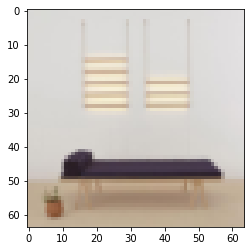

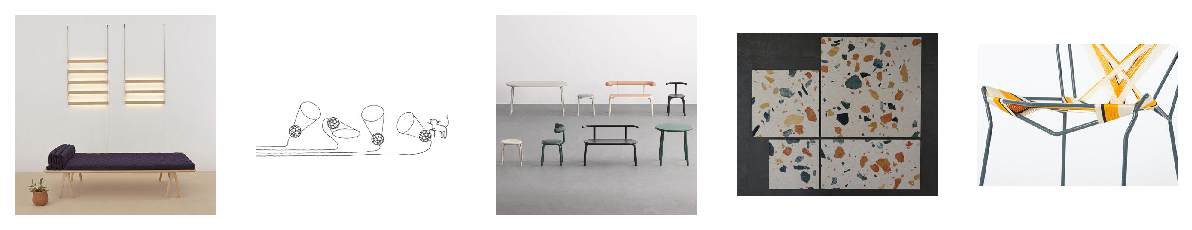

[3191, 6676, 294, 4890, 3057, 5864, 4705, 6917, 2615, 965, 2492, 4003, 6692, 4046, 3330, 1416, 1988, 3935, 2094, 3427, 4296, 3880, 4287, 5785, 3621, 5964, 6803, 2727, 1384, 2821, 242, 3960, 1682, 5708, 3839, 784, 4313, 6991, 2745, 594, 7215, 1793, 6436, 3878, 2647, 3888, 6204, 2617, 6606, 2369]
true labels:  ['stained', 'natural', 'classic', 'visual', 'simple', 'wooden', 'comfortable', 'successful', 'twentieth-century', 'flexible', 'red', 'asymmetric', 'storyfront', 'early', 'london-based', 'lightweight', 'black', 'robust', 'cnc-cut']
pred labels:  ['upended', 'spouted', 'cushioned', 'swell', 'neocon', 'inspite', 'squashed', 'unconstrained', 'moooi', 'rotund', 'noce', 'accentuated', 'saturnine', 'masterly', 'decontextualised', 'stark', 'unstoppable', 'mesmerised', 'tame', 'unrestrained', 'perfectionistic', 'canalside', 'metsidian', 'personified', 'pseudo', 'todays', 'undisciplined', 'slick', 'stepping', 'weathered', 'crafty', 'tessellating', 'areesh', 'punchy', 'plumb', 'contoured', 'l

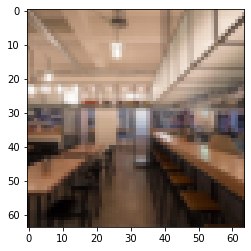

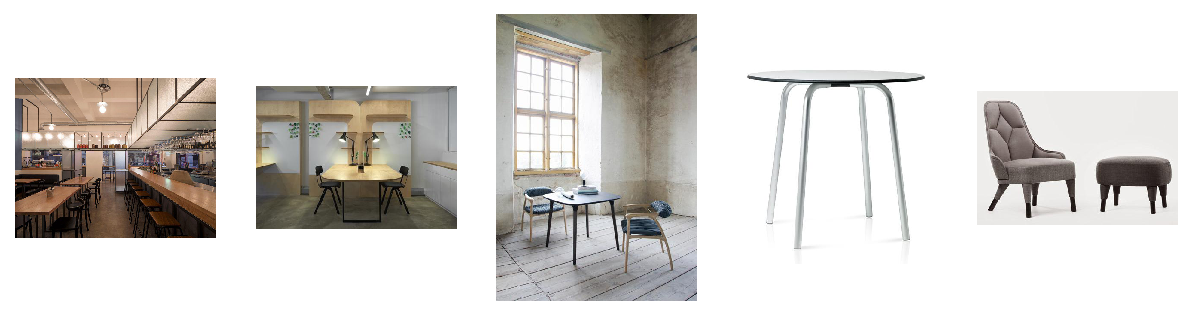

[1170, 4790, 3191, 4565, 1416, 2761, 5770, 6780, 7369, 743, 5864, 7036, 5359, 6898, 6991, 5295, 4796, 3878, 3435, 6071, 3729, 3689, 4296, 5649, 2519, 933, 2776, 4588, 336, 4705, 6720, 6507, 5054, 3471, 965, 2097, 4313, 955, 64, 5292, 4368, 1380, 6256, 1120, 3057, 5785, 6606, 3839, 4155, 5891]
true labels:  ['large', 'particular', 'great', 'fine', 'surprising', 'enjoyable', 'tired', 'modern', 'round', 'old', 'unique']
pred labels:  ['liquidy', 'pumiced', 'upended', 'chocolatey', 'stark', 'knobbly', 'sittable', 'moome', 'supersized', 'pearlescent', 'inspite', 'micro-living', 'brushed', 'nizwa', 'swish', 'ecru', 'lathed', 'modernistic', 'iroko', 'charcoaled', 'off-the-shelf', 'autoprogettazione', 'perfectionistic', 'ral', 'homey', 'disorienting', 'arabescato', 'absorbing', 'hand-crafted', 'squashed', 'olden', 'dupe', 'nutty', 'mindful', 'rotund', 'veneered', 'loopy', 'cocooned', 'stackable', 'noé', 'hackable', 'wide-ranging', 'saint-james', 'handblown', 'neocon', 'personified', 'diffused

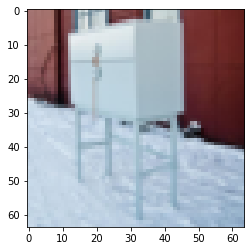

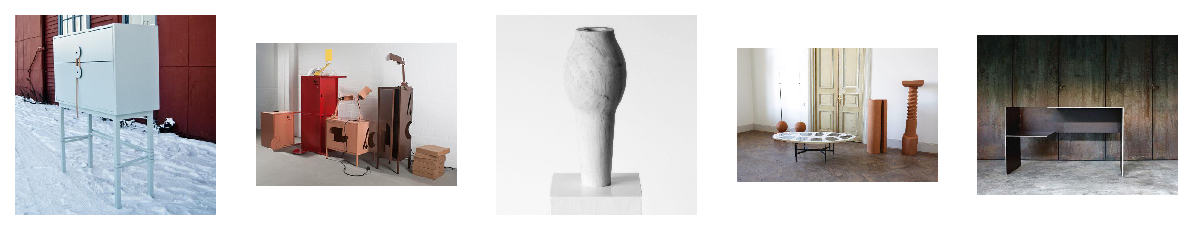

[1384, 3057, 918, 2039, 6272, 3471, 3191, 7264, 4678, 6991, 4954, 3194, 2615, 3932, 6692, 965, 2776, 4705, 2745, 1682, 4240, 5787, 1380, 6898, 3935, 6860, 5223, 1101, 3839, 5969, 3689, 1416, 2399, 5359, 5785, 1490, 1604, 367, 5864, 1335, 3330, 2046, 4790, 6256, 3427, 659, 4313, 7369, 4296, 2754]
true labels:  ['native', 'accessible', 'eco-package', 'fifth-placed', 'least', 'faceted', 'secret', 'single', 'visual', 'clean', 'unique', 'simple', 'outstanding', 'brilliant', 'innovative', 'endless', 'animal-shaped', 'attractive', 'perfect', 'useful', 'appealing', 'complex-looking', 'stable', 'corrugated-cardboard', 'popular', 'modular', 'minimum', 'wide', 'polar', 'distinctive', 'high', 'top', 'delicate', 'finalist', 'humble', 'practical', 'overall', 'creative', 'different', 'angular', 'public', 'sturdy', 'black']
pred labels:  ['stepping', 'neocon', 'inviting', 'stripy', 'paused', 'mindful', 'upended', 'distracted', 'whacked', 'swish', 'fabled', 'swift', 'moooi', 'sterling', 'saturnine', 'r

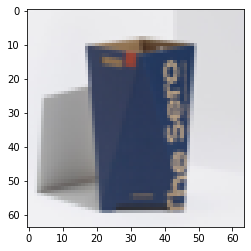

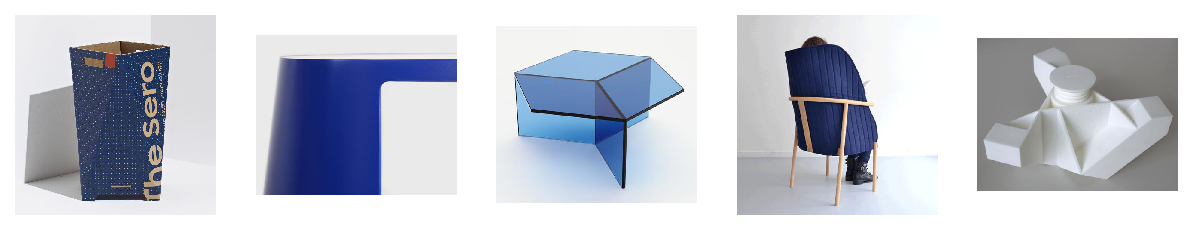

[2615, 5978, 4790, 7036, 3194, 1170, 3435, 2242, 5535, 1384, 3057, 1298, 2979, 4054, 1428, 980, 5292, 1458, 3689, 5530, 6603, 4940, 4238, 6692, 6991, 3040, 6207, 2745, 1282, 5650, 1490, 5121, 5153, 2039, 3191, 3839, 4705, 1101, 6780, 4954, 4796, 2727, 5894, 3960, 5295, 4296, 1395, 2944, 6898, 1714]
true labels:  ['tyrolean', 'triangular', 'rounded', 'contemporary', 'small', 'wooden', 'traditional', 'upside-down', 'solid']
pred labels:  ['moooi', 'disassemblable', 'pumiced', 'micro-living', 'swift', 'liquidy', 'iroko', 'arresting', 'compartmentalised', 'stepping', 'neocon', 'grid-like', 'lurvig', 'authorised', 'poppy', 'breakout', 'noé', 'reclaimed', 'autoprogettazione', 'coordinated', 'hammered', 'allcreatorstogether', 'daring', 'saturnine', 'swish', 'stand-alone', 'pressed', 'in-house', 'multicoloured', 'colous', 'chipboard', 'duplicable', 'fuseproject', 'stripy', 'upended', 'plumb', 'squashed', 'facetted', 'moome', 'fabled', 'lathed', 'slick', 'deconstructivist', 'tessellating', 'ec

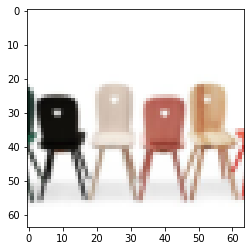

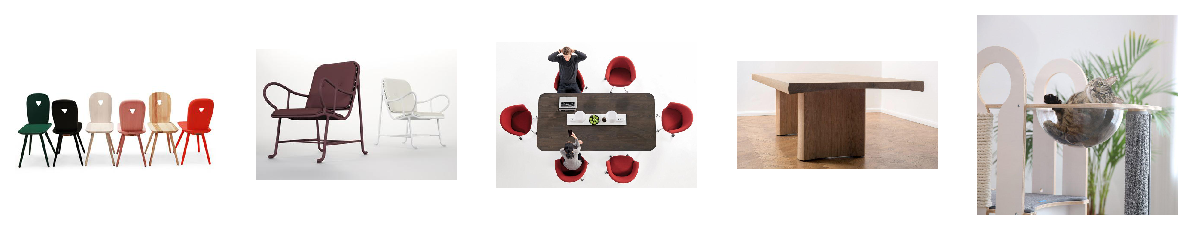

0

In [191]:
eval_model(model, all_embeds, val_dataloader)

In [143]:
from sklearn.manifold import TSNE

In [164]:
def plot_cluster(im_embeds):
    im_embds_name = list(im_embeds.keys())  # names
    im_embds_emb = list(im_embeds.values()) # embeddings
    im_embeddings_np = np.asarray(im_embds_emb).squeeze(1) # [17532, 50]
    rand_idxs = np.random.randint(17532, size=1000)
    
    samples = im_embeddings_np[rand_idxs, :]
    reduced_samples = TSNE(n_components=2).fit_transform(samples)

    plt.scatter(reduced_samples[:, 0], reduced_samples[:, 1])

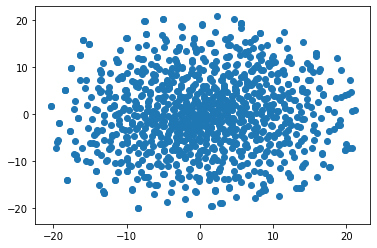

In [165]:
plot_cluster(all_embeds)